<a href="https://colab.research.google.com/github/holstbone/Neural-Networks-Music-Genres/blob/main/A_4_5_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A.4 Music "Vision"



# Andy's Work Starts Here:

## Part 5: Visualizing Activation Values of 128 node Dense layer using t-DSNE

In [ ]:
!python --version

Python 3.7.11


## Import Packages



In [ ]:
# Helper libraries
from time import time
import math
from packaging import version
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from sklearn.manifold import TSNE

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
print('The matplotlib version is {}.'.format(mpl.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The tensorflow version is {}.'.format(tf.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The scikit learn version is {}.'.format(sklearn.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The matplotlib version is 3.2.2.
The numpy version is 1.19.5.
The tensorflow version is 2.5.0.
The pandas version is 1.1.5.
The scikit learn version is 0.22.2.post1.
The seaborn version is 0.11.1.


## Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_path = '/content/drive/MyDrive/spectrograms3sec/data.zip'
!cp "{zip_path}" .
!unzip -q data.zip
!rm data.zip

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)



In [ ]:
test_it = datagen.flow_from_directory('data/test/',
                                      class_mode='categorical', 
                                      batch_size=250, 
                                      target_size=(128, 128))

test_steps_per_epoch = np.math.ceil(test_it.samples / test_it.batch_size)

Found 1000 images belonging to 10 classes.


In [ ]:
X, y = test_it.next()

In [ ]:
len(X)

250

In [ ]:
true_classes = np.argmax(y, axis=-1)

In [ ]:
true_classes

array([8, 0, 5, 4, 6, 2, 8, 4, 9, 1, 2, 5, 9, 5, 7, 3, 0, 7, 5, 4, 0, 5,
       8, 9, 8, 2, 7, 1, 2, 6, 0, 0, 5, 1, 0, 7, 2, 4, 2, 2, 2, 9, 0, 1,
       7, 5, 4, 8, 5, 7, 8, 3, 8, 8, 7, 4, 0, 5, 7, 5, 2, 4, 7, 2, 4, 9,
       0, 0, 6, 5, 0, 8, 7, 9, 0, 4, 3, 9, 1, 9, 3, 2, 0, 1, 5, 6, 6, 0,
       3, 9, 7, 0, 9, 5, 0, 7, 4, 3, 5, 0, 5, 3, 0, 8, 2, 1, 6, 0, 0, 9,
       8, 1, 1, 4, 8, 3, 6, 2, 1, 0, 1, 1, 4, 2, 1, 6, 4, 2, 0, 9, 1, 3,
       2, 8, 8, 6, 8, 5, 4, 5, 2, 4, 0, 3, 2, 5, 6, 8, 7, 3, 5, 8, 4, 4,
       7, 2, 3, 9, 6, 0, 2, 1, 3, 1, 8, 7, 6, 4, 7, 1, 6, 9, 6, 1, 7, 5,
       0, 2, 8, 0, 1, 3, 5, 2, 7, 9, 7, 4, 7, 9, 4, 6, 8, 4, 0, 2, 9, 5,
       2, 6, 6, 8, 5, 3, 9, 6, 3, 6, 8, 6, 4, 7, 6, 3, 1, 5, 9, 8, 7, 6,
       7, 1, 6, 4, 8, 6, 4, 7, 8, 1, 1, 0, 0, 3, 5, 6, 2, 3, 1, 1, 8, 2,
       9, 7, 1, 0, 8, 9, 5, 3])

In [ ]:
genres = list(test_it.class_indices.keys())
genres

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

### Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('/content/model_0.9090.h5')

## Predictions

In [ ]:
preds = model.predict(X)

In [ ]:
preds.shape

(250, 10)

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds, columns = genres)
df.style.format("{:.2%}").background_gradient(cmap=cm)

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
0,0.03%,0.01%,1.02%,11.85%,2.70%,0.53%,0.00%,11.98%,71.68%,0.20%
1,92.55%,0.01%,0.14%,0.00%,0.00%,7.29%,0.00%,0.00%,0.00%,0.01%
2,0.02%,0.27%,0.72%,0.01%,0.48%,97.62%,0.00%,0.41%,0.10%,0.37%
3,0.00%,0.00%,0.00%,0.00%,99.98%,0.00%,0.00%,0.01%,0.01%,0.00%
4,0.00%,0.00%,0.00%,0.00%,0.13%,0.00%,99.39%,0.00%,0.00%,0.47%
5,0.03%,0.01%,83.34%,0.27%,0.12%,0.03%,0.01%,15.07%,0.75%,0.36%
6,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%
7,0.00%,0.00%,0.02%,0.04%,97.24%,0.05%,0.00%,1.59%,1.03%,0.02%
8,0.02%,0.04%,4.57%,0.03%,0.04%,0.25%,2.84%,0.09%,0.02%,92.11%
9,0.00%,99.75%,0.00%,0.00%,0.00%,0.23%,0.00%,0.00%,0.00%,0.01%


 ### Get the activation values of the hidden nodes
 
To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [ ]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs; # description of the layers

There are 21 layers


In [ ]:
layer_outputs[19:21]

[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_36')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_37')>]

In [ ]:
# Get the outputs of all the hidden nodes for each of the 1000 test images
activations = activation_model.predict(X)
hidden_layer_activation = activations[19]
output_layer_activations = activations[20]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

(250, 128)

In [ ]:
output_layer_activations.shape

(250, 10)

In [ ]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 16.03095817565918


In [ ]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (250, 64, 64, 128)
The output for the first image are [[[0.    0.    0.    ... 0.    0.221 0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.281 0.   ]
  ...
  [0.    0.205 0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]]

 [[0.    0.    0.    ... 0.    0.03  0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.242 0.   ]
  ...
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]]

 [[0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.029 0.   ]
  ...
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]]

 ...

 [[0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0.    0.    ... 0.    0.    0.   ]
  [0.    0

 ### Create a dataframe with the activation values and the class labels

In [ ]:
#Get the dataframe of all the node values
activation_data = {'actual_class':true_classes}
for k in range(0,128): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head(15).round(3).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
actual_class,8.000,0.000,5.000,4.000,6.000,2.000,8.000,4.000,9.000,1.00,2.000,5.000,9.000,5.000,7.000
act_val_0,0.000,0.371,0.000,0.000,0.000,1.842,0.000,0.000,2.029,0.00,4.205,0.000,1.203,0.000,0.000
act_val_1,1.357,2.542,0.000,4.707,2.642,0.000,6.497,2.501,0.000,0.00,0.000,0.000,0.374,0.000,0.000
act_val_2,0.000,0.000,0.000,0.000,0.000,0.931,0.000,0.000,0.226,0.00,1.181,0.000,0.000,0.000,0.000
act_val_3,3.101,0.000,0.034,4.445,0.000,0.901,7.718,3.537,0.000,0.00,0.000,0.000,0.000,1.078,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act_val_123,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000
act_val_124,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000
act_val_125,0.000,2.400,0.254,0.000,0.000,0.000,0.000,0.000,0.000,3.66,0.000,3.875,1.605,1.618,0.000
act_val_126,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.000,0.000


### Use t-Distributed Stochastic Neighbor Embedding (**t-SNE**)  to reduce the (activation) features from 128 (= num of hidden nodes) to 2

`t-Distributed Stochastic Neighbor Embedding` (**t-SNE**) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. This time we only use the first 10,000 training images (N=10000) since the technique is computationally expensive.

See http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

<div class="alert alert-block alert-info">
    <b>Correlation matrix that measures the linear relationships</b><br> 
    https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html
    </div>

In [ ]:
activation_df.shape

(250, 129)

In [ ]:
N=250
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(250, 129)

In [ ]:
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
data_subset = activation_df_subset[features].values
data_subset.shape

(250, 128)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.009s...
[t-SNE] Computed neighbors for 250 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 6.489225
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.001099
[t-SNE] KL divergence after 300 iterations: 0.607702


In [ ]:
tsne_results = (tsne_results - tsne_results.min()) / (tsne_results.max() - tsne_results.min())

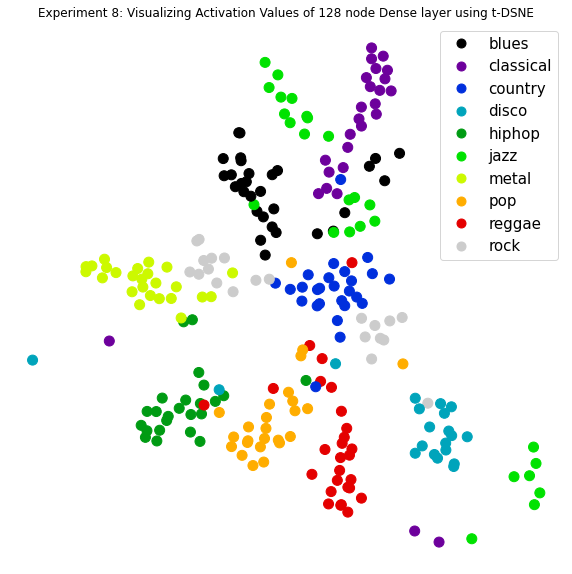

In [ ]:
# https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
# plt.figure(figsize=(10, 8))
cmap = plt.cm.nipy_spectral
plt.figure(figsize=(10,10))
scatter = plt.scatter(tsne_results[:,0],tsne_results[:,1], c=true_classes, s=100, cmap=cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=genres,fontsize=15, markerscale = 1.5)

#image_positions = np.array([[1., 1.]])
#for index, position in enumerate(tsne_results):
#    dist = np.sum((position - image_positions) ** 2, axis=1)
#    if np.min(dist) > 0.02: # if far enough from other images
#        image_positions = np.r_[image_positions, [position]]
#        imagebox = mpl.offsetbox.AnnotationBbox(
#            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
#            position, bboxprops={"edgecolor": cmap(y_train[index]), "lw": 2})
#        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.title('Experiment 8: Visualizing Activation Values of 128 node Dense layer using t-DSNE')
plt.savefig('Experiment_8')
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html /content/MSDS458_A_4_5_t_SNE.ipynb

[NbConvertApp] Converting notebook /content/MSDS458_A_4_5_t_SNE.ipynb to html
[NbConvertApp] Writing 885867 bytes to /content/MSDS458_A_4_5_t_SNE.html
